In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  2 11:48:00 2024

@author: chyga
"""
from scipy.special import expit
import numpy as np
import tensorly as tl
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from utils_binaryTensor_Sarah import TensorModelWithGenetics



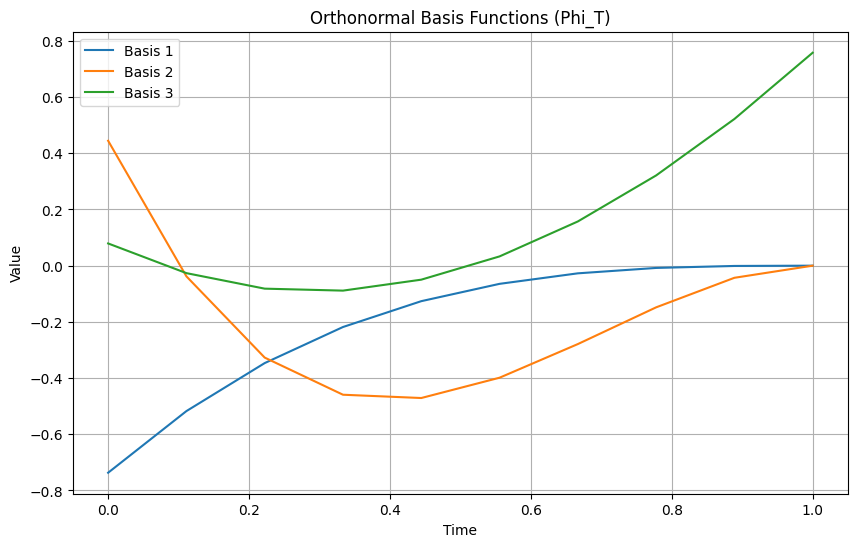

In [22]:


# set up the parameter 
# generate the outcomes with Sarah's model
## N is the dimension of subjects
## P is the dimension of X
## D is the dimension of disease
## K is the dimension of topics (or factors)
## R1 and R2 are the dimensions of basis functions
N, P, D, K, T = 1000, 20, 10, 5, 10
R1 = R2 = 3
np.random.seed(2)
# generate time points 
T_vec = np.linspace(0, 1, T)
# generate trend function
# h_1 = np.sin(0.2 * np.pi * T_vec)
# h_2 = T_vec * (10 - T_vec)/10
# h_3 = np.cos(0.2 * np.pi * T_vec) + 1
h_1 = 4 * (1 - T_vec)**3  # early peaking
h_2 = 27 * T_vec * (1 - T_vec)**2  # middle peaking
h_3 = 4 * T_vec**3  # late peaking
Phi_T = np.vstack((h_1, h_2, h_3)).T
Phi_T, _ = np.linalg.qr(Phi_T)
# # generate B1 and B2 
# B1 = np.random.normal(size = (N, R1, 3))
# B2 = np.random.normal(size = (K, R2, 3))

T = 10  # number of time points
t = np.linspace(0, 1, T)

plt.figure(figsize=(10, 6))

for i in range(Phi_T.shape[1]):
    plt.plot(t, Phi_T[:, i], label=f'Basis {i+1}')

plt.title('Orthonormal Basis Functions (Phi_T)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# A1 = tl.tenalg.mode_dot(B1, Phi_T, 2)
# A2 = tl.tenalg.mode_dot(B2, Phi_T, 2)
true_model = TensorModelWithGenetics(N, P, D, K, R1, R2, T)
true_model.initialize_parameters()
theta_true = true_model.compute_theta()
X = true_model.G # the genetic covariates for each individual
# theta_true = np.einsum('irt, jrt -> ijt', 
#           A1, A2)


In [35]:


type_outcome = 'Binary'

if type_outcome == 'Binary':
    # generate outcomes for Gaussian
    error = np.random.normal(scale = 1, loc = 0, size = (N, D, T))
    Y = theta_true + error
if type_outcome == 'Binary':
    # generate binary outcomes
    error = np.random.logistic(scale = 1, loc = 0, size = (N, D, T))
    Y = ((theta_true + error)>0).astype('int')



In [4]:

# begin our estimation
A1, w, A2 = svds(Y.mean(axis = 2), k = K) # average over time
# A, D, G = svds(theta_pred_glm.mean(axis = 2), k = R) # average over time
A1 = A1 @ np.diag(np.sqrt(w))
A2 = np.diag(np.sqrt(w)) @ A2
A2 = A2.T


# A1 and A2:
# A1 (N x K) represents the average individual loadings across all time points.
# A2 (D x K) represents the average disease loadings across all time points.
# These can be thought of as the "time-independent" or "average" loadings for individuals and diseases respectively.

#For each individual n and factor k, there are R1 coefficients that determine how that individual's loading on that factor varies over time.
# Similarly, for each disease d and factor k, there are R2 coefficients that determine how that disease's loading on that factor varies over time.

Initialize with genetic effects by computing least squares 

In [29]:
# Perform regression of A1 on G
B_init, _, _, _ = np.linalg.lstsq(true_model.G, A1, rcond=None)

# Reshape B_init to match the required shape of B
B = B_init.reshape(P, K, 1).repeat(R1, axis=2)
B.shape

(20, 5, 3)

In [19]:
## question: so in the first SVD, we are only doing the two dimension mode? (i.e., NxK not NxKxR?)
print(A1.shape) ## Individuls x K 
print(A2.shape)## Disease x K 
print(w.shape) ## KxK


(1000, 5)
(10, 5)
(5,)


In [9]:
# # construct 10th order Legendre polynomial  basis function for the time mode
# def basis(n, x): 
#     if(n == 0):
#         return 1 # P0 = 1
#     elif(n == 1):
#         return x # P1 = x
#     else:
#         return (((2 * n)-1)*x * basis(n-1, x)-(n-1)* basis(n-2, x))/float(n)

# Phi_G = []
# # Phi_G.append(
# #    np.ones(shape=(T_train))/T)
# for deg in range(1, (P+1)):
#     Phi_G.append( basis(deg, T_vec))

# Phi_G = np.column_stack(Phi_G)
# Phi_G, _ = np.linalg.qr(Phi_G)

# # Phi_A equals to Phi_G
# Phi_A = Phi_G
# the basis functions are the truth, similar to my U2 and U3, should by TxR
Phi_A1 = Phi_A2 = Phi_T
Phi_T.shape
## Time x R



(10, 3)

In [34]:
# Compute genetic effect
genetic_effect = np.einsum('np,pkr->nkr', true_model.G, B)

# Add genetic effect to B1
B1 += genetic_effect

# Project B1 onto the space spanned by all covariates
X_combined = np.concatenate([X, true_model.G], axis=1)
B1 = tl.tenalg.mode_dot(B1, X_combined @ np.linalg.pinv(X_combined.T @ X_combined) @ X_combined.T, mode = 0)
B1.shape

(1000, 5, 3)

In [20]:


## It starts with A1 (N x K), expands it to (N x K x T).
## It then projects this expanded tensor onto the basis functions Phi_A1 (T x R).
## The result, B1, is (N x K x R), directly analogous to U1

B1 = tl.tenalg.mode_dot(np.repeat(A1[:, :, np.newaxis], T, axis = 2),
                       np.linalg.pinv(Phi_A1.T @ Phi_A1) @ Phi_A1.T, mode = 2)
B1.shape

## 

#This line of code is performing an important operation: it's projecting B1 onto the space spanned by the covariates X. Let's break it down step by step:
#1. X @ np.linalg.pinv(X.T @ X) @ X.T:
# This is computing the projection matrix for X.
# np.linalg.pinv(X.T @ X) calculates the pseudoinverse of X'X.
# Multiplying this by X on both sides gives us the projection matrix onto the column space of X.
#tl.tenalg.mode_dot(B1, ..., mode = 0):
# This applies the projection matrix to B1 along mode 0 (which corresponds to the individuals).
# It's equivalent to multiplying each "slice" of B1 (for each combination of k and r) by the projection matrix.

# project B1 onto the space spanned by the covariates,
#B1 = tl.tenalg.mode_dot(B1, X @ np.linalg.pinv(X.T @ X) @ X.T, mode = 0)
#B1.shape 


(1000, 5, 3)

In [26]:
##genetic_effect = np.einsum('np,pkr->nkr', true_model.G, true_model.B)

# Add the genetic effect to B1
# B1 += genetic_effect

# Then project B1 onto the space spanned by the covariates
B1 = tl.tenalg.mode_dot(B1, X @ np.linalg.pinv(X.T @ X) @ X.T, mode = 0)
B1.shape


(1000, 5, 3)

In [ ]:
# project A2 onto the space spanned by the time bases
B2 = tl.tenalg.mode_dot(np.repeat(A2[:, :, np.newaxis], T, axis = 2),
                       np.linalg.pinv(Phi_A2.T @ Phi_A2) @ Phi_A2.T, mode = 2)
# A = np.repeat(A[:, :, np.newaxis], Phi_A.shape[1], axis = 2)
# G = np.repeat(G[:, :, np.newaxis], Phi_G.shape[1], axis = 2)
# D is the diagnoal term
# D_T = np.repeat(D[:, np.newaxis], T_train, axis = 1)
# begin gradient descent for optimization


In [14]:
print(B1.shape) # should be N x K x R1
print(B2.shape) # should be D x K x R2



(1000, 5, 3)
(10, 5, 3)


## model comparison:
U2 ≈ Phi_A1 (see initialization of H stacks into Phi_T)
U3 ≈ Phi_A2 (from real values)
# A1 (N x K) represents the average individual loadings across all time points, results form SVDI
# A2 (D x K) represents the average disease loadings across all time points, results from SVD
U1(G) ≈ B1 (but B1 includes both genetic and non-genetic effects) after projection of average over time 
 A1 (from SVD) on bases
W ≈ B2, similarly with Disease
G is used in the projection of B1, but not explicitly separated -- no C?

fitting continued: 
A1_T and A2_T are the time-varying versions of B1 and B2 (i.e., Lambda and Phi)
Theta is computed similarly in both models
B1 = genetic_effect + non_genetic_effect
A1_T = tl.tenalg.mode_dot(B1, Phi_A1, 2)

In [ ]:

stepsize = .1
alpha = 0.5; beta = 0.8 # backtracking line search
rho = 1
stepsize_B1 = stepsize_B2 = stepsize
# the time is the last mode (i.e, t_idx = 1)
t_idx = len(Y.shape) - 1
niters = 1000
for it in range(niters):
    # A1 is time-varying loaded with genetic covariates
    A1_T = tl.tenalg.mode_dot(B1, Phi_A1, 2)
    # A2 is time-varying loading of diseases
    A2_T = tl.tenalg.mode_dot(B2, Phi_A2, 2)
    
    theta_pre = np.einsum("irt, jrt -> ijt", 
                          A1_T, A2_T)
    
    if type_outcome == 'Gaussian':
        L_nabula = -Y + theta_pre
    
    # record the loss function post-GD
    # d(-L(θ))/dθ = σ(θ) - Y
    # This computes the gradient of the negative log-likelihood with respect to theta
    
    if type_outcome == 'Binary':
        L_nabula = -Y + expit(theta_pre)
    
    # unfold along the first mode at each time
    L_nabula_mode0 = np.stack([tl.unfold(L_nabula[:, :, idx], mode = 0) for 
                                     idx in range(L_nabula.shape[t_idx])],
                                    axis = t_idx)
    L_nabula_mode1 = np.stack([tl.unfold(L_nabula[:, :, idx], mode = 1) for 
                                     idx in range(L_nabula.shape[t_idx])],
                                    axis = t_idx)
    
    # record the loss function pre-GD
    if type_outcome == 'Gaussian':
        loss_pre = np.sum((Y - theta_pre)**2)/N
    
    if type_outcome == 'Binary':
        loss_pre = (- Y * theta_pre + np.log(1 + np.exp(theta_pre))).sum()/N
    
    
    # grad_f_X_unflod_mode3 = tl.unfold(L_nabula, mode = 2)
    grad_B2 = tl.tenalg.mode_dot(np.einsum('ijt, jrt -> irt', 
                                          L_nabula_mode1, A1_T),
                                Phi_A2.T, 2) #+ rho * B2
    
    B2_tilde = B2 - stepsize_B2 * grad_B2
    

    if type_outcome == 'Gaussian':
        loss_after = np.sum((Y - np.einsum("irt, jrt -> ijt", A1_T, 
                              tl.tenalg.mode_dot(B2_tilde, Phi_A2, 2)))**2)/N
   
    if type_outcome == 'Binary':
        loss_after = (- Y * np.einsum("irt, jrt -> ijt", A1_T, 
                              tl.tenalg.mode_dot(B2_tilde, Phi_A2, 2)) +\
                      np.log(1 + np.exp(np.einsum("irt, jrt -> ijt", A1_T, 
                                            tl.tenalg.mode_dot(B2_tilde, Phi_A2, 2))))).sum()/N
# This computes the gradient of the negative log-likelihood with respect to theta, as we discussed earlier.
# The next two lines are creating unfolded versions of this gradient tensor:

    
    
    if(loss_after > loss_pre - alpha * \
        stepsize_B2 * 1/np.linalg.norm(grad_B2)):
        # return to previous stage
        stepsize_B2 *= beta
    else:
        B2 = B2_tilde
        A2_T = tl.tenalg.mode_dot(B2, Phi_A2, 2)
        # scale the G_T
        
    
    # grad for U1
    # X.T @ 
    grad_B1 = tl.tenalg.mode_dot(np.einsum('ijt, jrt -> irt', 
                                          L_nabula_mode0, A2_T),
                                Phi_A1.T, 2) #+ rho * B1
    
    B1_tilde = B1 - stepsize_B1 * grad_B1
    B1_tilde = tl.tenalg.mode_dot(B1_tilde, X @ np.linalg.pinv(X.T @ X) @ X.T, mode = 0)

    # record the loss function post-GD
    ## with back-track line search
    if type_outcome == 'Gaussian':
        loss_after = np.sum((Y - np.einsum("irt, jrt -> ijt", 
                                            tl.tenalg.mode_dot(B1_tilde, Phi_A1, 2), 
                                            A2_T))**2)/N
    
    if type_outcome == 'Binary':
        loss_after = (- Y * np.einsum("irt, jrt -> ijt", 
                                            tl.tenalg.mode_dot(B1_tilde, Phi_A1, 2), 
                                            A2_T) + \
                      np.log(1 + np.exp(np.einsum("irt, jrt -> ijt", 
                                                          tl.tenalg.mode_dot(B1_tilde, Phi_A1, 2), 
                                                          A2_T)))).sum()/N
    
    
    
    if(loss_after > loss_pre - alpha * \
        stepsize_B1 * 1/np.linalg.norm(grad_B1)):
        # return to previous stage
        stepsize_B1 *= beta
    else:
        B1 = B1_tilde
        A1_T = tl.tenalg.mode_dot(B1, Phi_A1, 2)
    
    theta_after = np.einsum("irt, jrt -> ijt", A1_T, A2_T)
    
    if type_outcome == 'Gaussian':
        loss_after = np.sum((Y - theta_after)**2)/N
    
    if type_outcome == 'Binary':
        loss_after = (- Y * theta_after + np.log(1 + np.exp(theta_after))).sum()/N
                                                                                  
    # record the relative loss change
    tol_temp = np.abs(np.linalg.norm(loss_pre) - np.linalg.norm(loss_after))/\
        np.linalg.norm(loss_pre)
    
    if not (it % 100):
        print(f'{it}th iteration with loss: {np.round(loss_after,3)}')
        # print()
    if tol_temp < 1e-5 and (stepsize_B1 < 1e-6 or stepsize_B2 < 1e-6):
        print('Stop: not enough improvement')
        break

# theta_pred_glm = get_theta_binary_stratified(Y = Y,
#                                   X = np.ones((N, 1)))
# loss_glm = (- Y * theta_pred_glm + np.log(1 + np.exp(theta_pred_glm))).sum()/N
# loss_glm
loss_after
# time-varying loadings
A2_T = tl.tenalg.mode_dot(B2, Phi_A2, 2)  
A1_T = tl.tenalg.mode_dot(B1, Phi_A1, 2)  
theta_fit = np.einsum("irt, jrt -> ijt", A1_T, A2_T)
# scale the time-varying loadings at each time
# for t in range(T_train):
#     G_T[:, :, t] = abs(G_T[:, :, t])/ \
#         np.sqrt((G_T[:, :, t]**2).mean(axis = 0))[np.newaxis, :]
# time-varying loadings
# plt.plot((G_T[:,0,:]).T/(G_T[:,0,:]).mean(),
#          color = '#66C2A5') 
# plt.plot((G_T[:,1,:]).T/(G_T[:,1,:]).mean(),
#          color = '#FC8D62') 
# plt.plot((G_T[:,2,:]).T/(G_T[:,2,:]).mean(),
#          color = '#8DA0CB') 


In [ ]:
pi_true = expit(theta_true)
pi_fit = expit(theta_fit)
# Plot true vs estimated pi for a few randomly selected individuals and diseases
num_samples = 5
sample_individuals = np.random.choice(N, num_samples, replace=False)
sample_diseases = np.random.choice(D, num_samples, replace=False)

plt.figure(figsize=(15, 15))
for i, (n, d) in enumerate(zip(sample_individuals, sample_diseases)):
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(pi_true[n, d, :], label='True')
    plt.plot(pi_fit[n, d, :], label='Estimated')
    plt.title(f'Individual {n}, Disease {d}')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.scatter(pi_true[n, d, :], pi_fit[n, d, :])
    plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
    plt.xlabel('True Probability')
    plt.ylabel('Estimated Probability')
    plt.title(f'True vs Estimated (Ind {n}, Disease {d})')

plt.tight_layout()
plt.show()

# Your method computes gradients for each parameter separately.
# ##The other method uses tensor unfolding and mode_dot operations.
Optimization:
You use a fixed learning rate with early stopping and gradient clipping.
The other method uses backtracking line search for step size adjustment.

In [ ]:
## my fitting approach 

def compute_U1G(self):
        U1G = self.U1.copy()
        genetic_effect = np.einsum('np,pkr->nkr', self.G, self.B)
        U1G += genetic_effect + self.C
        return U1G

    def compute_theta(self):
        U1G = self.compute_U1G()
        lambda_k = np.einsum('nkr,tr->nkt', U1G, self.fixed_U2)
        phi = np.einsum('dkr,tr->dkt', self.W, self.fixed_U3)
        theta = np.einsum('nkt,dkt->ndt', lambda_k, phi)
        return theta

    def survival_likelihood(self, Y, S):
        theta = self.compute_theta()
        pi = expit(theta)
        log_likelihood = 0
        for n in range(self.N):
            for d in range(self.D):
                t = S[n, d]
                log_likelihood += np.sum(np.log(1 - pi[n, d, :t] + 1e-10))
                if Y[n, d, t] == 1:
                    log_likelihood += np.log(pi[n, d, t] + 1e-10)
                    pi[n, d, t+1:] = 0
        return log_likelihood

    def compute_gradients(self, Y, S):
        theta = self.compute_theta()
        pi = expit(theta)
        U1G = self.compute_U1G()
        lambda_k = np.einsum('nkr,tr->nkt', U1G, self.fixed_U2)
        phi = np.einsum('dkr,tr->dkt', self.W, self.fixed_U3)
        
        d_theta = np.zeros_like(theta)
        for n in range(self.N):
            for d in range(self.D):
                t = S[n, d]
                d_theta[n, d, :t] = -pi[n, d, :t]
                if Y[n, d, t] == 1:
                    d_theta[n, d, t] += 1
        
        d_lambda = np.einsum('ndt,dkt->nkt', d_theta, phi)
        d_phi = np.einsum('ndt,nkt->dkt', d_theta, lambda_k)
        
        d_U1G = np.einsum('nkt,tr->nkr', d_lambda, self.fixed_U2)
        d_W = np.einsum('dkt,tr->dkr', d_phi, self.fixed_U3)
        
        d_U1 = d_U1G
        d_B = np.einsum('nkr,np->pkr', d_U1G, self.G)
        d_C = d_U1G
        
        return d_U1, d_W, d_B, d_C

    def fit(self, Y, S, num_iterations=1000, learning_rate=1e-4, l2_reg=1e-5, clip_value=1.0, patience=50):
        if not self.initialized:
            raise ValueError("Parameters have not been initialized yet.")
        
        losses = []
        best_loss = -np.inf
        patience_counter = 0
        
        for iteration in range(num_iterations):
            log_likelihood = self.survival_likelihood(Y, S)
            loss = log_likelihood - l2_reg * (np.sum(self.U1**2) + np.sum(self.W**2) + np.sum(self.B**2) + np.sum(self.C**2))
            losses.append(loss)
            
            if loss > best_loss:
                best_loss = loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at iteration {iteration}")
                    break
            
            d_U1, d_W, d_B, d_C = self.compute_gradients(Y, S)
            
            d_U1 = np.clip(d_U1, -clip_value, clip_value)
            d_W = np.clip(d_W, -clip_value, clip_value)
            d_B = np.clip(d_B, -clip_value, clip_value)
            d_C = np.clip(d_C, -clip_value, clip_value)
            
            self.U1 += learning_rate * (d_U1 - 2 * l2_reg * self.U1)
            self.W += learning_rate * (d_W - 2 * l2_reg * self.W)
            self.B += learning_rate * (d_B - 2 * l2_reg * self.B)
            self.C += learning_rate * (d_C - 2 * l2_reg * self.C)
            
            if iteration % 10 == 0:
                print(f"Iteration {iteration}, Log-likelihood: {log_likelihood}")
        
        return losses